<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
Models benchmark : JuMP vs OptimalControl 

<div style ="width:90%;
            font-size:0.75em;
            text-align:center;">
 <i>For Goddard Rocket Problem</i></div>
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
We will compare the performance of JuMP and OptimalControl for the Goddard Rocket Problem. The Goddard Rocket Problem is a classic optimal control problem where the goal is to maximize the final altitude of a rocket by controlling the thrust.
We will compare the results of the two packages with different linear solvers:

1. [MUMPS](#mumps)
2. [HSL_MA27](#ma27)
3. [HSL_MA57](#ma57)
4. [Conclusions](#cl)

</div>

Importing the necessary packages

In [1]:
using BenchmarkTools
using Plots
using DataFrames
using CTDirect, CTBase
using JuMP, OptimalControl
using Ipopt
import HSL_jll
include("./utils.jl")
include("../Problems/JuMP/rocket_JMP.jl")
include("../Problems/OptimalControl/rocket_OC.jl")

## 1. MUMPS Linear solver <a id='mumps'></a>

### With JuMP

In [2]:
RocketJMP = rocket_JMP();

set_optimizer(RocketJMP,Ipopt.Optimizer)
set_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"tol",1e-8)
set_optimizer_attribute(RocketJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RocketJMP,"max_iter",1000)
set_optimizer_attribute(RocketJMP,"mu_strategy","adaptive")
set_optimizer_attribute(RocketJMP,"linear_solver","mumps")
bJMP_mumps = @benchmark (optimize!(RocketJMP))

unset_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"output_file","rocketJMP.out")
optimize!(RocketJMP)

N = 100;
Δt = RocketJMP[:step]; 
h = RocketJMP[:h];
v = RocketJMP[:v];
m = RocketJMP[:m];
T = RocketJMP[:T];
Δtt = value.(Δt)
t_mumps = Vector((0:N)*Δtt);
hh = Vector(value.(h)) ;
vv = Vector(value.(v)) ;
mm = Vector(value.(m)) ;
TT_mumps = Vector(value.(T)) ;

x_mumps =  [ [ hh[i], vv[i], mm[i] ] for i in 1:N+1 ];


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality c

### With OptimalControl

In [3]:
RocketOC = rocket_OC()

nh = 100
m_0 = 1.0
g_0 = 1.0
T_c = 3.5
m_c = 0.6
m_f = m_c * m_0
T_max = T_c * m_0 * g_0

xinit = [1.0*ones(nh), (0:nh)./nh .* (1.0 .- (0:nh)/nh) ,(m_f - m_0).*((0:nh)./nh) .+ m_0]
init = CTBase.OCPInit((x_init = xinit,u_init =  ones(nh).*T_max/2.0 ,v_init= 1))
sol_mumps = OptimalControl.solve(RocketOC,init=init,output_file="rocketOC.out");
bOC_mumps = @benchmark (OptimalControl.solve(RocketOC,init=init,display=false));

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0100000e+00 3.96e-01 2.00e+00   0.

### Results summary for MUMPS

In [4]:
results_mumps = DataFrame( :method => String[], 
                :nvar => Int64[],
                :ncon => Int64[],
                :niter => Int64[],
                :nonzero_jac => Int64[],
                :nonzero_hess => Int64[],
                :diff_auto_time => String[] , 
                :total_time => String[],
                :objective_value => Float64[],
            );
push!(results_mumps,[ "JuMP" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);
push!(results_mumps,[ "OptimalControl" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);

outputJMP = read("rocketJMP.out", String)
tipopt = parse(Float64,split(split(outputJMP, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_mumps[results_mumps.method .== "JuMP",:nvar] .= MOI.get(RocketJMP, MOI.NumberOfVariables());
results_mumps[results_mumps.method .== "JuMP",:ncon] .= length(all_constraints(RocketJMP; include_variable_in_set_constraints = false))
results_mumps[results_mumps.method .== "JuMP",:total_time] .= prettytime(median(bJMP_mumps.times));
results_mumps[results_mumps.method .== "JuMP",:niter] .= solution_summary(RocketJMP).barrier_iterations
results_mumps[results_mumps.method .== "JuMP",:objective_value] .= objective_value(RocketJMP)
results_mumps[results_mumps.method .== "JuMP",:nonzero_jac] .= jac_hess_nnz_JMP(RocketJMP)[1]
results_mumps[results_mumps.method .== "JuMP",:nonzero_hess] .= jac_hess_nnz_JMP(RocketJMP)[2]
results_mumps[results_mumps.method .== "JuMP",:diff_auto_time] .= tipopt


nlpOC = directTranscription(RocketOC).nlp
outputOC = read("rocketOC.out", String)
tipopt = parse(Float64,split(split(outputOC, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_mumps[results_mumps.method .== "OptimalControl",:nvar] .= nlpOC.meta.nvar;
results_mumps[results_mumps.method .== "OptimalControl",:ncon] .= nlpOC.meta.ncon;
results_mumps[results_mumps.method .== "OptimalControl",:niter] .= sol_mumps.iterations;
results_mumps[results_mumps.method .== "OptimalControl",:total_time] .= prettytime(median(bOC_mumps.times));
results_mumps[results_mumps.method .== "OptimalControl",:objective_value] .= sol_mumps.objective;
results_mumps[results_mumps.method .== "OptimalControl",:nonzero_jac] .= nlpOC.meta.nnzj;
results_mumps[results_mumps.method .== "OptimalControl",:nonzero_hess] .= nlpOC.meta.nnzh;
results_mumps[results_mumps.method .== "OptimalControl",:diff_auto_time] .= tipopt;



-----

## 2. HSL_MA27 Linear solver <a id='ma27'></a>

### With JuMP

In [5]:
RocketJMP = rocket_JMP();

set_optimizer(RocketJMP,Ipopt.Optimizer)
set_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"tol",1e-8)
set_optimizer_attribute(RocketJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RocketJMP,"max_iter",1000)
set_optimizer_attribute(RocketJMP,"mu_strategy","adaptive")
set_attribute(RocketJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(RocketJMP, "linear_solver", "ma27")
bJMP_ma27 = @benchmark (optimize!(RocketJMP))

unset_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"output_file","rocketJMP.out")
optimize!(RocketJMP)

N = 100;
Δt = RocketJMP[:step]; 
h = RocketJMP[:h];
v = RocketJMP[:v];
m = RocketJMP[:m];
T = RocketJMP[:T];
Δtt = value.(Δt)
t_ma27 = Vector((0:N)*Δtt);
hh = Vector(value.(h)) ;
vv = Vector(value.(v)) ;
mm = Vector(value.(m)) ;
TT_ma27 = Vector(value.(T)) ;

x_ma27 =  [ [ hh[i], vv[i], mm[i] ] for i in 1:N+1 ];

This is Ipopt version 3.14.14, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

### With OptimalControl

In [6]:
RocketOC = rocket_OC()

nh = 100
m_0 = 1.0
g_0 = 1.0
T_c = 3.5
m_c = 0.6
m_f = m_c * m_0
T_max = T_c * m_0 * g_0

xinit = [1.0*ones(nh), (0:nh)./nh .* (1.0 .- (0:nh)/nh) ,(m_f - m_0).*((0:nh)./nh) .+ m_0]
init = CTBase.OCPInit((x_init = xinit,u_init =  ones(nh).*T_max/2.0 ,v_init= 1))
sol_ma27 = OptimalControl.solve(RocketOC,init=init,output_file="rocketOC.out",linear_solver="ma27",hsllib=HSL_jll.libhsl_path);
bOC_ma27 = @benchmark (OptimalControl.solve(RocketOC,init=init,display=false,linear_solver="ma27",hsllib=HSL_jll.libhsl_path));

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0100000e+00 3.96e-01 2.00e+00   0.0 0.00e

### Results summary for HSL_MA27

In [7]:
results_ma27 = DataFrame( :method => String[], 
                :nvar => Int64[],
                :ncon => Int64[],
                :niter => Int64[],
                :nonzero_jac => Int64[],
                :nonzero_hess => Int64[],
                :diff_auto_time => String[] , 
                :total_time => String[],
                :objective_value => Float64[],
            );
push!(results_ma27,[ "JuMP" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);
push!(results_ma27,[ "OptimalControl" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);

outputJMP = read("rocketJMP.out", String)
tipopt = parse(Float64,split(split(outputJMP, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_ma27[results_ma27.method .== "JuMP",:nvar] .= MOI.get(RocketJMP, MOI.NumberOfVariables());
results_ma27[results_ma27.method .== "JuMP",:ncon] .= length(all_constraints(RocketJMP; include_variable_in_set_constraints = false))
results_ma27[results_ma27.method .== "JuMP",:total_time] .= prettytime(median(bJMP_ma27.times));
results_ma27[results_ma27.method .== "JuMP",:niter] .= solution_summary(RocketJMP).barrier_iterations
results_ma27[results_ma27.method .== "JuMP",:objective_value] .= objective_value(RocketJMP)
results_ma27[results_ma27.method .== "JuMP",:nonzero_jac] .= jac_hess_nnz_JMP(RocketJMP)[1]
results_ma27[results_ma27.method .== "JuMP",:nonzero_hess] .= jac_hess_nnz_JMP(RocketJMP)[2]
results_ma27[results_ma27.method .== "JuMP",:diff_auto_time] .= tipopt


nlpOC = directTranscription(RocketOC).nlp
outputOC = read("rocketOC.out", String)
tipopt = parse(Float64,split(split(outputOC, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_ma27[results_ma27.method .== "OptimalControl",:nvar] .= nlpOC.meta.nvar;
results_ma27[results_ma27.method .== "OptimalControl",:ncon] .= nlpOC.meta.ncon;
results_ma27[results_ma27.method .== "OptimalControl",:niter] .= sol_ma27.iterations;
results_ma27[results_ma27.method .== "OptimalControl",:total_time] .= prettytime(median(bOC_ma27.times));
results_ma27[results_ma27.method .== "OptimalControl",:objective_value] .= sol_ma27.objective;
results_ma27[results_ma27.method .== "OptimalControl",:nonzero_jac] .= nlpOC.meta.nnzj;
results_ma27[results_ma27.method .== "OptimalControl",:nonzero_hess] .= nlpOC.meta.nnzh;
results_ma27[results_ma27.method .== "OptimalControl",:diff_auto_time] .= tipopt;


-----

## 3. HSL_MA57 Linear solver <a id='ma57'></a>

### With JuMP

In [8]:
RocketJMP = rocket_JMP();

set_optimizer(RocketJMP,Ipopt.Optimizer)
set_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"tol",1e-8)
set_optimizer_attribute(RocketJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RocketJMP,"max_iter",1000)
set_optimizer_attribute(RocketJMP,"mu_strategy","adaptive")
set_attribute(RocketJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(RocketJMP, "linear_solver", "ma57")
bJMP_ma57 = @benchmark (optimize!(RocketJMP))

unset_silent(RocketJMP)
set_optimizer_attribute(RocketJMP,"output_file","rocketJMP.out")
optimize!(RocketJMP)

N = 100;
Δt = RocketJMP[:step]; 
h = RocketJMP[:h];
v = RocketJMP[:v];
m = RocketJMP[:m];
T = RocketJMP[:T];
Δtt = value.(Δt)
t_ma57 = Vector((0:N)*Δtt);
hh = Vector(value.(h)) ;
vv = Vector(value.(v)) ;
mm = Vector(value.(m)) ;
TT_ma57 = Vector(value.(T)) ;

x_ma57 =  [ [ hh[i], vv[i], mm[i] ] for i in 1:N+1 ];

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

### With OptimalControl

In [9]:
RocketOC = rocket_OC()

nh = 100
m_0 = 1.0
g_0 = 1.0
T_c = 3.5
m_c = 0.6
m_f = m_c * m_0
T_max = T_c * m_0 * g_0

xinit = [1.0*ones(nh), (0:nh)./nh .* (1.0 .- (0:nh)/nh) ,(m_f - m_0).*((0:nh)./nh) .+ m_0]
init = CTBase.OCPInit((x_init = xinit,u_init =  ones(nh).*T_max/2.0 ,v_init= 1))
sol_ma57 = OptimalControl.solve(RocketOC,init=init,output_file="rocketOC.out",linear_solver="ma57",hsllib=HSL_jll.libhsl_path);
bOC_ma57 = @benchmark (OptimalControl.solve(RocketOC,init=init,display=false,linear_solver="ma57",hsllib=HSL_jll.libhsl_path));

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0100000e+00 3.96e-01 2.00e+00   0.0 0.00e

### Results summary for HSL_MA57

In [10]:
results_ma57 = DataFrame( :method => String[], 
                :nvar => Int64[],
                :ncon => Int64[],
                :niter => Int64[],
                :nonzero_jac => Int64[],
                :nonzero_hess => Int64[],
                :diff_auto_time => String[] , 
                :total_time => String[],
                :objective_value => Float64[],
            );
push!(results_ma57,[ "JuMP" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);
push!(results_ma57,[ "OptimalControl" , NaN , NaN , NaN , NaN , NaN , NaN , NaN , NaN], promote=true);

outputJMP = read("rocketJMP.out", String)
tipopt = parse(Float64,split(split(outputJMP, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_ma57[results_ma57.method .== "JuMP",:nvar] .= MOI.get(RocketJMP, MOI.NumberOfVariables());
results_ma57[results_ma57.method .== "JuMP",:ncon] .= length(all_constraints(RocketJMP; include_variable_in_set_constraints = false))
results_ma57[results_ma57.method .== "JuMP",:total_time] .= prettytime(median(bJMP_ma57.times));
results_ma57[results_ma57.method .== "JuMP",:niter] .= solution_summary(RocketJMP).barrier_iterations
results_ma57[results_ma57.method .== "JuMP",:objective_value] .= objective_value(RocketJMP)
results_ma57[results_ma57.method .== "JuMP",:nonzero_jac] .= jac_hess_nnz_JMP(RocketJMP)[1]
results_ma57[results_ma57.method .== "JuMP",:nonzero_hess] .= jac_hess_nnz_JMP(RocketJMP)[2]
results_ma57[results_ma57.method .== "JuMP",:diff_auto_time] .= tipopt


nlpOC = directTranscription(RocketOC).nlp
outputOC = read("rocketOC.out", String)
tipopt = parse(Float64,split(split(outputOC, "Total seconds in IPOPT                               =")[2], "\n")[1])
results_ma57[results_ma57.method .== "OptimalControl",:nvar] .= nlpOC.meta.nvar;
results_ma57[results_ma57.method .== "OptimalControl",:ncon] .= nlpOC.meta.ncon;
results_ma57[results_ma57.method .== "OptimalControl",:niter] .= sol_ma57.iterations;
results_ma57[results_ma57.method .== "OptimalControl",:total_time] .= prettytime(median(bOC_ma57.times));
results_ma57[results_ma57.method .== "OptimalControl",:objective_value] .= sol_ma57.objective;
results_ma57[results_ma57.method .== "OptimalControl",:nonzero_jac] .= nlpOC.meta.nnzj;
results_ma57[results_ma57.method .== "OptimalControl",:nonzero_hess] .= nlpOC.meta.nnzh;
results_ma57[results_ma57.method .== "OptimalControl",:diff_auto_time] .= tipopt;


-----

## 4. Conclusion <a id='cl'></a>

<div style="width:90%;
            margin:9px;
            font-size:1em;"> 
            

**Note :** We can choose the tool of computation we want to display (plots, tables, benchmark outputs) and for which solver we want to display the results.
</div>

In [11]:
# results displayed
plotting = true;
benchmark = true;
table = true;
# solvers 
mumps = true;
hslma27 = true;
hslma57 = true;

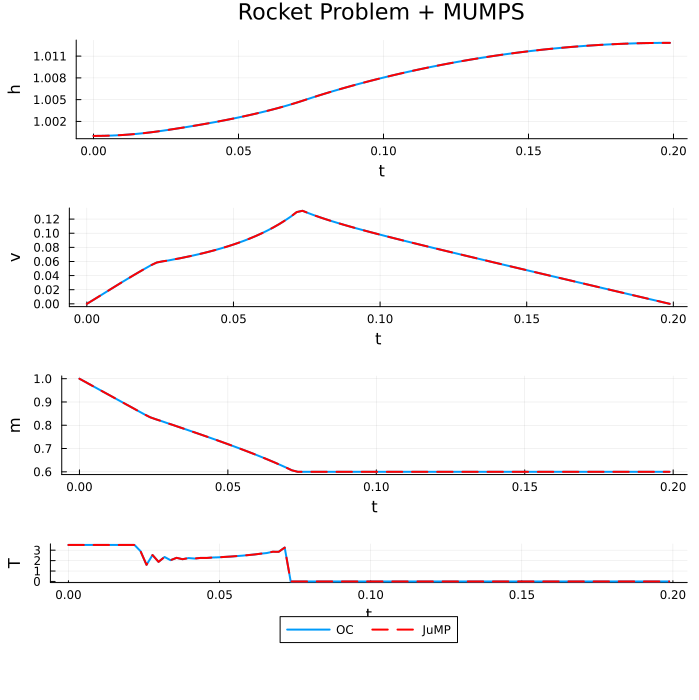

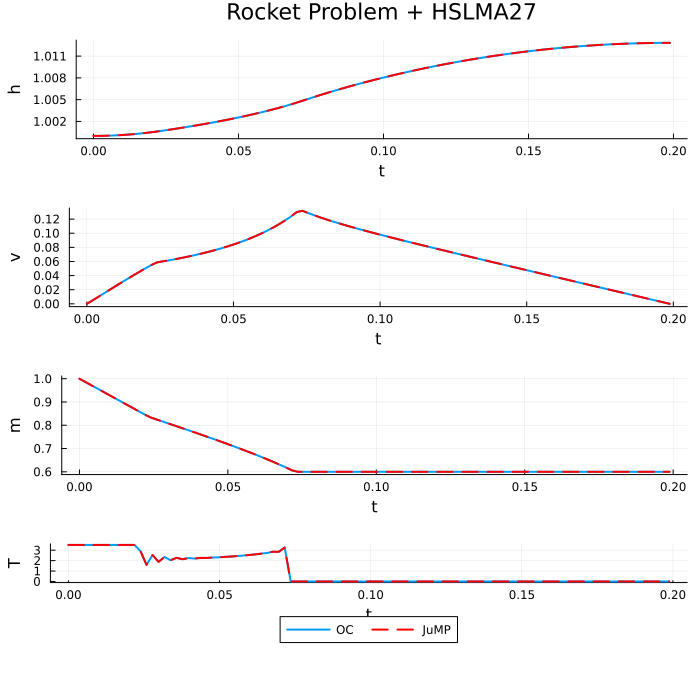

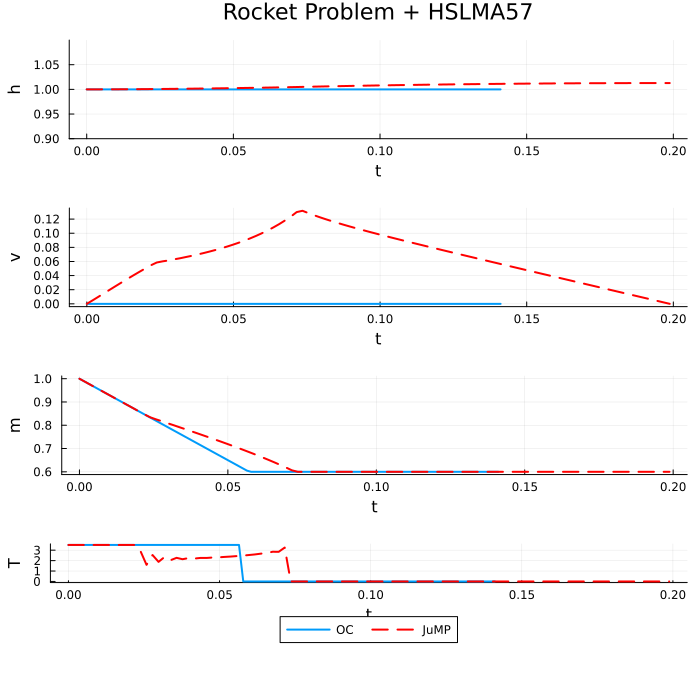

--------------------------------MUMPS--------------------------------
------------JuMP : 
BenchmarkTools.Trial: 156 samples with 1 evaluation.
 Range (min … max):  21.896 ms … 56.393 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     27.944 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   30.938 ms ±  7.926 ms  ┊ GC (mean ± σ):  0.48% ± 3.68%

    ▅  ▅█▇▅▄▃▄▃                                                
  ▇▇█▅▇█████████▆▃▇▅▅▇▆▃▃▁▁▇▁▃▅▁▁▅▃▅▅▆▃▆▅▁▆▃▃▅▁▁▃▁▁▁▁▃▁▁▁▅▃▁▃ ▃
  21.9 ms         Histogram: frequency by time          54 ms <

 Memory estimate: 175.78 KiB, allocs estimate: 6716.

------------OptimalControl : 
BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.218 s …    2.457 s  ┊ GC (min … max): 3.83% … 3.21%
 Time  (median):     2.250 s               ┊ GC (median):    3.78%
 Time  (mean ± σ):   2.308 s ± 129.991 ms  ┊ GC (mean ± σ):  4.55% ± 1.88%

  █      █                                                 █  
  █▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

In [12]:
#cell to run for results
if plotting 
    if mumps 
        p1 = plot(plot(sol_mumps)[1],line = 2)
        p1 = plot!(t_mumps, [ x_mumps[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false,line = 2, color = "red",linestyle=:dash)
        title!(p1, "Rocket Problem + MUMPS", titlefontsize = 15)  

        p2 = plot(plot(sol_mumps)[2],line = 2)
        p2 = plot!(t_mumps, [ x_mumps[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

        p3 = plot(plot(sol_mumps)[3],line = 2)
        p3 = plot!(t_mumps, [ x_mumps[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false,line = 2, color = "red",linestyle=:dash)
        
        p4 = plot(plot(sol_mumps)[7] , label ="OC",line = 2)
        p4 = plot!(t_mumps, [ TT_mumps[i] for i in 1:N+1 ], xlabel = "t", ylabel = "T", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
        p4 = plot!(legend=:outerbottom, legendcolumns=2)

        layout = @layout [a; b; c; d]
        
        x_plot = plot(p1, p2, p3, p4, layout = layout)
        x_plot = plot!(size = (700, 700))
        display(x_plot)
    end
    if hslma27 
        p1 = plot(plot(sol_ma27)[1],line = 2)
        p1 = plot!(t_ma27, [ x_ma27[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false,line = 2, color = "red",linestyle=:dash)
        title!(p1, "Rocket Problem + HSLMA27", titlefontsize = 15)  

        p2 = plot(plot(sol_ma27)[2],line = 2)
        p2 = plot!(t_ma27, [ x_ma27[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

        p3 = plot(plot(sol_ma27)[3],line = 2)
        p3 = plot!(t_ma27, [ x_ma27[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false,line = 2, color = "red",linestyle=:dash)
        
        p4 = plot(plot(sol_ma27)[7] , label ="OC",line = 2)
        p4 = plot!(t_ma27, [ TT_ma27[i] for i in 1:N+1 ], xlabel = "t", ylabel = "T", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
        p4 = plot!(legend=:outerbottom, legendcolumns=2)

        layout = @layout [a; b; c; d]
        
        x_plot = plot(p1, p2, p3, p4, layout = layout)
        x_plot = plot!(size = (700, 700))
        display(x_plot)
    end
    if hslma57 
        p1 = plot(plot(sol_ma57)[1],line = 2)
        p1 = plot!(t_ma57, [ x_ma57[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false,line = 2, color = "red",linestyle=:dash)
        title!(p1, "Rocket Problem + HSLMA57", titlefontsize = 15)  

        p2 = plot(plot(sol_ma57)[2],line = 2)
        p2 = plot!(t_ma57, [ x_ma57[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

        p3 = plot(plot(sol_ma57)[3],line = 2)
        p3 = plot!(t_ma57, [ x_ma57[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false,line = 2, color = "red",linestyle=:dash)
        
        p4 = plot(plot(sol_ma57)[7] , label ="OC",line = 2)
        p4 = plot!(t_ma57, [ TT_ma57[i] for i in 1:N+1 ], xlabel = "t", ylabel = "T", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
        p4 = plot!(legend=:outerbottom, legendcolumns=2)

        layout = @layout [a; b; c; d]
        
        x_plot = plot(p1, p2, p3, p4, layout = layout)
        x_plot = plot!(size = (700, 700))
        display(x_plot)
    end
end
if benchmark
    if mumps
        println("--------------------------------MUMPS--------------------------------")
        println("------------JuMP : ")
        show(stdout ,"text/plain",bJMP_mumps)
        println();println();
        println("------------OptimalControl : ")
        show(stdout ,"text/plain",bOC_mumps)
        println();println();
    end
    if hslma27
        println("--------------------------------HSLMA27--------------------------------")
        println("------------JuMP : ")
        show(stdout ,"text/plain",bJMP_ma27)
        println();println();
        println("------------OptimalControl : ")
        show(stdout ,"text/plain",bOC_ma27)
        println();println();
    end
    if hslma57
        println("--------------------------------HSLMA57--------------------------------")
        println("------------JuMP : ")
        show(stdout ,"text/plain",bJMP_ma57)
        println();println();
        println("------------OptimalControl : ")
        show(stdout ,"text/plain",bOC_ma57)
        println();println();
    end
end
if table 
    if mumps
        printstyled("-----------------------------------------------------------MUMPS------------------------------------------------------------",color = :blue);
        println()
        println(results_mumps);
    end
    if hslma27
        printstyled("-----------------------------------------------------------HSLMA27----------------------------------------------------------",color = :blue);
        println()
        println(results_ma27)
    end
    if hslma57
        printstyled("-----------------------------------------------------------HSLMA57----------------------------------------------------------",color = :blue);
        println()
        println(results_ma57)
    end
end

---------------------
